In [1]:
%matplotlib widget
import os
import sys
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import math

# Problem definiation

In [2]:
ypr_gt = [45/180.0*math.pi, -15/180.0*math.pi, 20/180.0*math.pi]
t_gt = [1, -2, 3]
x_gt = np.append(ypr_gt, t_gt)

np.random.seed(10)
pts_model = np.random.rand(10, 3) + np.array([1, 2, 3])
#print(pts_model)

In [3]:
R_gt = Rotation.from_euler('ZYX', ypr_gt, degrees=False).as_matrix()
pts_target = (R_gt @ pts_model.T).T + t_gt

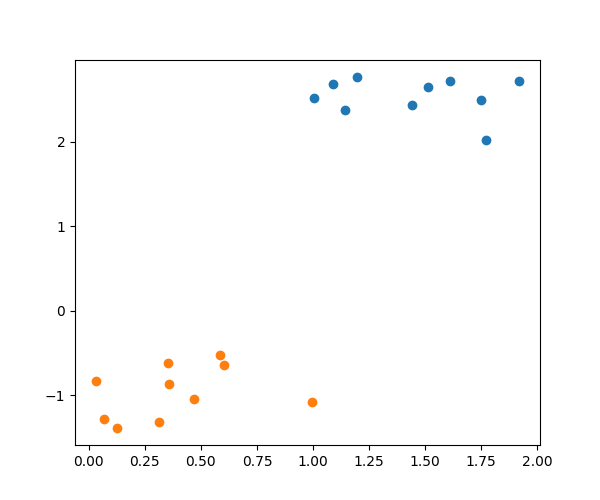

In [4]:
plt.figure(figsize=(6,5))
plt.scatter(pts_model[:, 0], pts_model[:, 1])
plt.scatter(pts_target[:, 0], pts_target[:, 1])

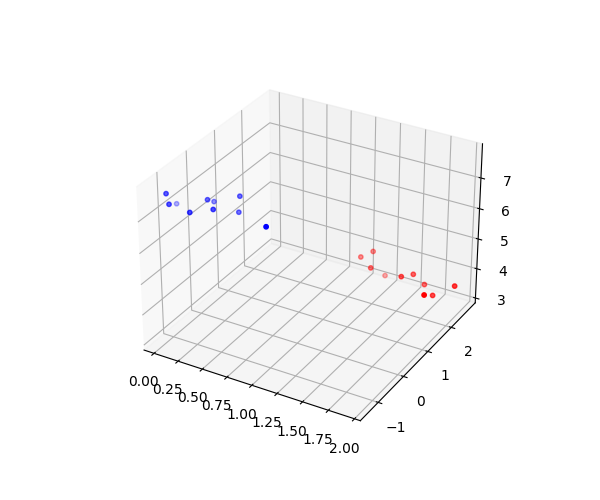

In [5]:
def viz_solution(pts_model, pts_target, pts_model_hat=None):
    plt.figure(figsize=(6,5))
    ax = plt.axes(projection='3d')
    ax.scatter3D(pts_model[:,0], pts_model[:,1], pts_model[:,2], c='r', s=10)
    ax.scatter3D(pts_target[:,0], pts_target[:,1], pts_target[:,2], c='b', s=10)
    if pts_model_hat is not None:
        ax.scatter3D(pts_model_hat[:,0], pts_model_hat[:,1], pts_model_hat[:,2], c='g', s=10)

viz_solution(pts_model, pts_target)

# Solution based on SVD

Details: https://igl.ethz.ch/projects/ARAP/svd_rot.pdf

In [6]:
cog_model = np.mean(pts_model, axis=0)
cog_target = np.mean(pts_target, axis=0)

pts_model_cog = pts_model - cog_model
pts_target_cog = pts_target - cog_target

In [7]:
C = pts_model_cog.T @ pts_target_cog

In [8]:
# %% SVD decomposition
[U, S, V] = np.linalg.svd(C)
V = V.T
C_chk = U @ np.diag(S) @ V.T
print('Check decomposition ( =0): ', np.linalg.norm(C_chk - C))

Check decomposition ( =0):  6.93249415984657e-16


In [9]:
R_svd = V @ U.T
t_svd = cog_target - R_svd @ cog_model

print('Check R ( =0): ', np.linalg.norm(R_svd - R_gt))
print('Check t ( =0):', np.linalg.norm(t_svd - t_gt))

Check R ( =0):  9.777686967753793e-16
Check t ( =0): 2.7012892057857038e-15


In [10]:
pts_model_hat = (R_svd @ pts_model.T).T + t_svd

In [11]:
res_svd = np.linalg.norm(pts_model_hat - pts_target, axis=1)
print('Check transformation ( =0)', np.linalg.norm(res_svd))

Check transformation ( =0) 1.1046579618885443e-15


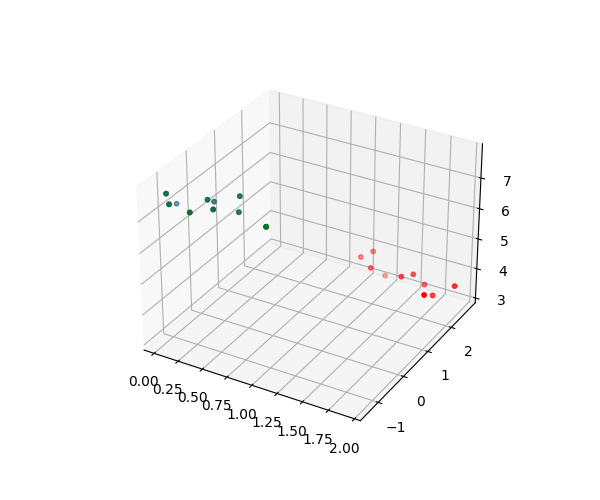

In [12]:
viz_solution(pts_model, pts_target, pts_model_hat)

# Solution with derivative-free built-in function

In [13]:
from scipy.optimize import minimize

In [14]:
R_x =  lambda x0: Rotation.from_euler('ZYX', x0[:3], degrees=False).as_matrix()
r_x = lambda x0: ((R_x(x0) @ pts_model.T).T + np.array([x0[3:6]]) - pts_target).ravel()
print('Check residual function ( =0): ', np.linalg.norm(r_x(x_gt)))

Check residual function ( =0):  0.0


We will use the derivative free simplex method.

In [15]:
x0 = np.array([45.0-5.0, -15.0+5.0, 20.0+3.0, 1.0+0.3, -2.0+0.3, 3.0-0.2])
x0[:3] *= 1.0/180.0*math.pi
#x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    
res = minimize(lambda x: r_x(x).T @ r_x(x), x0, method='nelder-mead',
               options={'xatol': 1e-6, 'disp': True})

print('Check solution ( =0): ', np.linalg.norm(res.x - x_gt))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 414
         Function evaluations: 668
Check solution ( =0):  1.345659728811918e-07


As we can see this method is relatively sensitive to the choosen initial guess.

# Solution with Newton's method

In [16]:
import sympy as sym
from math import cos, sin, pi

In order to improve on the convergence rate and hopefully improve on the sensitivity of the initial guess, let's try to use analytical derivatives.

In [17]:
o, p, k, x, y, z = sym.symbols('o p k x y z')

In [18]:
def Rx_s(theta):
  return sym.Matrix([[ 1, 0           , 0           ],
                   [ 0, sym.cos(theta),-sym.sin(theta)],
                   [ 0, sym.sin(theta), sym.cos(theta)]])
  
def Ry_s(theta):
  return sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-sym.sin(theta), 0, sym.cos(theta)]])
  
def Rz_s(theta):
  return sym.Matrix([[sym.cos(theta), -sym.sin(theta), 0 ],
                   [ sym.sin(theta), sym.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

ypr2rot_sym = lambda k, p, o: Rz_s(k) @ Ry_s(p) @ Rx_s(o)
#print('Check rotation composition ( =0)', np.linalg.norm(R_fn(ypr_gt[0], ypr_gt[1], ypr_gt[2]) - R_gt))

In [19]:
R_sym = ypr2rot_sym(k, p, o)
R_sym_sub = R_sym.subs({k: float(ypr_gt[0]), p: float(ypr_gt[1]), o: float(ypr_gt[2])})
R_sym_sub_np = np.array(R_sym_sub.tolist()).astype('float')
print('Check rotation composition ( =0): ', np.linalg.norm(R_sym_sub_np - R_gt))

Check rotation composition ( =0):  5.028663855320258e-16


Define cost function:

In [20]:
dt_sym = np.tile(np.array([x, y, z]), (pts_model.shape[0], 1))
res_sym_vec = (R_sym @ pts_model.T).T + dt_sym - pts_target
res_sym_vec = res_sym_vec.reshape(pts_model.shape[0]*3, 1) # reshape it from (N x 3) -> (M x 1)
cost_fn_sym = res_sym_vec.T @ res_sym_vec

print('Shape of analytical cost function (= (1,1)): ', cost_fn_sym.shape)
print('Number of chars of cost function :', len(str(cost_fn_sym)), '  ', len(str(cost_fn_sym))/1000, 'kB')

Shape of analytical cost function (= (1,1)):  (1, 1)
Number of chars of cost function : 5651    5.651 kB


Define & lambdify gradient function: 

In [21]:
g = sym.Matrix([cost_fn_sym.diff(var) for var in [k, p, o, x, y, z]])
g_x_sym = lambda x0: g.subs({k: float(x0[0]), p: float(x0[1]), o: float(x0[2]), 
                             x: float(x0[3]), y: float(x0[4]), z: float(x0[5])})
g_x = lambda x0: np.array(g_x_sym(x0).tolist()).astype('float')
print('Check gradient (= 0): ', np.linalg.norm(g_x(x_gt)))

Check gradient (= 0):  7.928205151735809e-14


Define & lambdify Hessian matrix: 

In [22]:
H = sym.hessian(cost_fn_sym, [k, p, o, x, y, z])
H_x_sym = lambda x0: H.subs({k: float(x0[0]), p: float(x0[1]), o: float(x0[2]), 
                             x: float(x0[3]), y: float(x0[4]), z: float(x0[5])})
H_x = lambda x0: np.array(H_x_sym(x0).tolist()).astype('float')

print('Shape of Hessian (= (6,6)) : ', H_x(x_gt).shape)
print('Min value of Eigenvalues (> 0): ', np.min(np.linalg.eigvals(H_x(x_gt))))
print('Number of chars of Hessian function :', len(str(H)), '  ', len(str(H))/1000, 'kB')

Shape of Hessian (= (6,6)) :  (6, 6)
Min value of Eigenvalues (> 0):  0.07609313347492956
Number of chars of Hessian function : 121273    121.273 kB


Solve the problem with Newton's method. The method should exhibit quadratic convergence if x0 is "good enough".

In [23]:
print('Iteration # {:6s} {:18s} {:15s} {:20s}'.format('', 'delta gt', 'dx', 'dr'))
print('----------------------------------------------------------------')
def print_iter(iter_num, chk, dx, dr):
    print('Iteration #{:d} {:15.8f} {:15.8f} {:15.8f}'.format(iter_num, chk, dx, dr))

x0 = np.array([45.0-5.0, -15.0+5.0, 20.0+3.0, 1.0+0.3, -2.0+0.3, 3.0-0.2])
x0[:3] *= 1.0/180.0*pi
#x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

dx = np.inf
iter_num = 0

print_iter(iter_num, np.linalg.norm(x0 - x_gt), np.nan, np.linalg.norm(g_x(x0)))
while np.linalg.norm(dx) > 1e-6 and iter_num < 20:
    iter_num += 1
    dx = np.linalg.inv(H_x(x0)) @ g_x(x0)
    dx = dx.reshape(-1)
    x0 = x0 - dx
    print_iter(iter_num, np.linalg.norm(x0 - x_gt), np.linalg.norm(dx), np.linalg.norm(r_x(x0)))

Iteration #        delta gt           dx              dr                  
----------------------------------------------------------------
Iteration #0      0.48782418             nan     88.15605575
Iteration #1      0.47796358      0.86260594      0.11954077
Iteration #2      0.03553601      0.45497213      0.10702280
Iteration #3      0.01680323      0.03225956      0.00393932
Iteration #4      0.00005742      0.01677698      0.00014884
Iteration #5      0.00000007      0.00005739      0.00000001
Iteration #6      0.00000000      0.00000007      0.00000000


In [24]:
print('Check solution ( =0): ', np.linalg.norm(x0 - x_gt))

Check solution ( =0):  1.1322018805647075e-13


It seems this solution is also sensitive for the initial guess.

# Solution of the cost with built-in methods

In [25]:
from scipy.optimize import minimize

For better convergence properties, we can do line search with the Hessian. In the next we will use built-in function that utilizes this technique. 

In [26]:
cost_per_iter = []
def iter_callback(xk):
    dx_gt = np.linalg.norm(xk - x_gt)
    cost_per_iter.append(dx_gt)
    print('Norm from GT: ', dx_gt)

x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
res = minimize(lambda x: r_x(x).T @ r_x(x), x0, method='Newton-CG',
               jac=lambda x: g_x(x).reshape(-1),  hess=H_x,
               options={'xtol': 1e-6, 'disp': True, 'maxiter': 50}, callback=iter_callback)

Norm from GT:  3.7041334871323515
Norm from GT:  3.577176390835075
Norm from GT:  3.169818529572525
Norm from GT:  2.3804327842374886
Norm from GT:  1.9538234545973174
Norm from GT:  1.851903232452018
Norm from GT:  1.8510280613872954
Norm from GT:  1.8347093851800722
Norm from GT:  1.6325057461235404
Norm from GT:  1.6320873270816365
Norm from GT:  1.35008310577427
Norm from GT:  1.339390931516075
Norm from GT:  1.1426353982315502
Norm from GT:  0.7107197198908385
Norm from GT:  0.7104004738750256
Norm from GT:  0.7091042496902825
Norm from GT:  0.7054949796181825
Norm from GT:  0.6315047978981243
Norm from GT:  0.47423513112531024
Norm from GT:  0.4714697183615809
Norm from GT:  0.39808851901825093
Norm from GT:  0.23560043914369014
Norm from GT:  0.23554561244392122
Norm from GT:  0.18292540171743266
Norm from GT:  0.06368381218366174
Norm from GT:  0.0633687297226316
Norm from GT:  0.0442506245176184
Norm from GT:  0.0002500605157893692
Norm from GT:  0.00014859211706738602
Norm fr

Text(0.5, 1.0, 'Convergence of Newton-CG method')

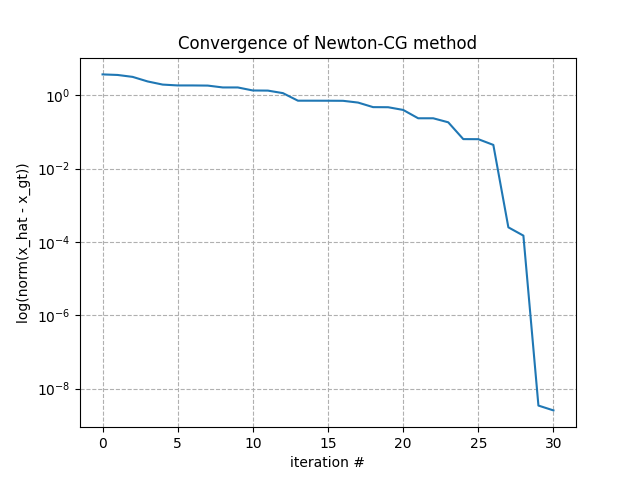

In [27]:
plt.figure()
plt.plot(range(len(cost_per_iter)), cost_per_iter)
plt.yscale('log')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('log(norm(x_hat - x_gt))')
plt.xlabel('iteration #')
plt.title("Convergence of Newton-CG method")

# Solution with Gauss-Newton method

We should take advantage of the fact that the problem is least squares. This will allow us to use more stable algorithms with faster convergence rate and with less sensitivity to the initial guess.

Create the Jacobian matrix for the least squares problem:

In [28]:
J = res_sym_vec.jacobian([k, p, o, x, y, z])
J_x_sym = lambda x0: J.subs({k: float(x0[0]), p: float(x0[1]), o: float(x0[2]), 
                             x: float(x0[3]), y: float(x0[4]), z: float(x0[5])})
J_x = lambda x0: np.array(J_x_sym(x0).tolist()).astype('float')
N = J_x(x0).T @ J_x(x0)


print('Shape of Jacobian: ', J.shape)
print('Shape of N: ', N.shape)
print('Number of chars of Jacobian function :', len(str(J)), '  ', len(str(J))/1000, 'kB')

Shape of Jacobian:  (30, 6)
Shape of N:  (6, 6)
Number of chars of Jacobian function : 10622    10.622 kB


... and the iterations looks more stable:

In [29]:
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
dx = np.inf
iter_num = 0

print_iter(iter_num, np.linalg.norm(x0 - x_gt), np.nan, np.linalg.norm(r_x(x0)))
while np.linalg.norm(dx) > 1e-6 and iter_num < 20:
    iter_num += 1
    dr = r_x(x0)
    dx = np.linalg.inv(J_x(x0).T @ J_x(x0)) @ J_x(x0).T @ dr
    x0 = x0 - dx
    print_iter(iter_num, np.linalg.norm(x0 - x_gt), np.linalg.norm(dx), np.linalg.norm(dr))

Iteration #0      3.84801717             nan     16.88998476
Iteration #1      1.51626838      4.81285259     16.88998476
Iteration #2      0.08253915      1.48703868      3.25424394
Iteration #3      0.00005337      0.08252769      0.26340997
Iteration #4      0.00000000      0.00005337      0.00020193
Iteration #5      0.00000000      0.00000000      0.00000000


Surpresingly, almost quadratic convergence from the beginning with an initial guess far from the solution. However the above approach results in long Jacobian code. Instead we can compute the symbolic Jacobian for each point separatetly.

In [30]:
m_x, m_y, m_z = sym.symbols('m_x m_y m_z')
t_x, t_y, t_z = sym.symbols('t_x t_y t_z')

m_xyz = np.array([m_x, m_y, m_z])
t_xyz = np.array([t_x, t_y, t_z])

dt_sym_row = np.array([x, y, z])
eq_sym = (R_sym @ m_xyz).T + dt_sym_row - t_xyz

print('Shape of a single point pair equation: (= (3,))', eq_sym.shape)

Shape of a single point pair equation: (= (3,)) (3,)


In [31]:
J_point_tx = sym.Matrix([eq_sym[0].diff(x) for x in [k, p, o, x, y, z]]).T
J_point_ty = sym.Matrix([eq_sym[1].diff(x) for x in [k, p, o, x, y, z]]).T
J_point_tz = sym.Matrix([eq_sym[2].diff(x) for x in [k, p, o, x, y, z]]).T
J_point = sym.Matrix([J_point_tx, J_point_ty, J_point_tz])

print('Number of chars of Jacobian function :', len(str(J_point)), '  ', len(str(J_point))/1000, 'kB')

Number of chars of Jacobian function : 685    0.685 kB


In [32]:
J_point_sym = lambda x0, m_pt, t_pt: J_point.subs({k: float(x0[0]), p: float(x0[1]), o: float(x0[2]), 
                                                   x: float(x0[3]), y: float(x0[4]), z: float(x0[5]),
                                                m_x: float(m_pt[0]), m_y: float(m_pt[1]), m_z: float(m_pt[2]),
                                                t_x: float(t_pt[0]), t_y: float(t_pt[1]), t_z: float(t_pt[2])})

J_point_x = lambda x0, m_pt, t_pt: np.array(J_point_sym(x0, m_pt, t_pt).tolist()).astype('float')

In [33]:
def build_J(x):
    J_x = np.zeros((pts_model.shape[0]*3, 6))
    for pt_k in range(pts_model.shape[0]):
        J_x[(pt_k*3):(pt_k*3+3)] = J_point_x(x, pts_model[pt_k, :], pts_target[pt_k, :])
    return J_x

print('Check Jacobian composition ( =0): ', np.linalg.norm(build_J(x_gt) - J_x(x_gt)))

Check Jacobian composition ( =0):  0.0


In [34]:
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
dx = np.inf
iter_num = 0

print_iter(iter_num, np.linalg.norm(x0 - x_gt), np.nan, np.linalg.norm(r_x(x0)))
while np.linalg.norm(dx) > 1e-6 and iter_num < 20:
    iter_num += 1
    dr = r_x(x0)
    dx = np.linalg.inv(build_J(x0).T @ build_J(x0)) @ build_J(x0).T @ dr
    x0 = x0 - dx
    print_iter(iter_num, np.linalg.norm(x0 - x_gt), np.linalg.norm(dx), np.linalg.norm(dr))

Iteration #0      3.84801717             nan     16.88998476
Iteration #1      1.51626838      4.81285259     16.88998476
Iteration #2      0.08253915      1.48703868      3.25424394
Iteration #3      0.00005337      0.08252769      0.26340997
Iteration #4      0.00000000      0.00005337      0.00020193
Iteration #5      0.00000000      0.00000000      0.00000000


# Solution with least squares and numerical differentiation

In [35]:
from scipy.optimize import least_squares

There are deravitive-free least squares algorithms that we can utilize to solve these types of problems faster & easier. 

In [52]:
x0 = np.array([0, 0, 0, 0, 0, 0])
res = least_squares(r_x, x0, verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4264e+02                                    2.23e+02    
       1              2         3.9256e+01      1.03e+02       1.00e+00       3.95e+01    
       2              3         1.4577e+01      2.47e+01       1.00e+00       1.64e+01    
       3              4         5.7868e-01      1.40e+01       2.00e+00       1.50e+01    
       4              5         1.7850e-01      4.00e-01       1.20e+00       6.12e+00    
       5              6         1.3188e-06      1.79e-01       1.49e-01       1.04e-02    
       6              7         2.5127e-19      1.32e-06       5.33e-04       6.26e-09    
`gtol` termination condition is satisfied.
Function evaluations 7, initial cost 1.4264e+02, final cost 2.5127e-19, first-order optimality 6.26e-09.


In [37]:
print('Check solution ( =0): ', np.linalg.norm(res.x - x_gt))

Check solution ( =0):  1.813613464495386e-10


# Solution with automatic differentiation

Follow this link: https://sidsite.com/posts/autodiff/

- Operations are primarly implemented as overloads
- All values are float inside the class
- We provide constant (number) overloads for convenience

In [38]:
from collections import defaultdict

class Variable:
    
    def __init__(self, value, local_gradients=[]):
        self.value = float(value)
        self.local_gradients = local_gradients

    def __float__(self):
         return self.value
    
    def __add__(self, other):
        if not isinstance(other, Variable):
            return self.__add__(Variable(float(other)))        
        value = self.value + other.value    
        local_gradients = ((self, 1.0), (other, 1.0))
        return Variable(value, local_gradients)
    
    def __mul__(self, other):
        if not isinstance(other, Variable):
            return self.__mul__(Variable(float(other)))
        value = self.value * other.value
        local_gradients = ((self, other.value), (other, self.value))
        return Variable(value, local_gradients)

    def __neg__(self):
        value = -1.0 * self.value
        local_gradients = ((self, -1.0),)
        return Variable(value, local_gradients)
    
    def __sub__(self, other):
        if not isinstance(other, Variable):
            return self.__sub__(Variable(float(other)))        
        return self.__add__(other.__neg__())
    
    def __repr__(self):
        return str(self.value) + 'v' # + ' [' + str(self.local_gradients) + ']'

    __radd__  = __add__
    __rmul__ = __mul__
    __rsub__ = __sub__

class VarFunctions:
    def sin(a):
        value = np.sin(a.value)
        local_gradients = (
            (a, np.cos(a.value)),
        )
        return Variable(value, local_gradients)

    def cos(a):
        value = np.cos(a.value)
        local_gradients = (
            (a, -np.sin(a.value)),
        )
        return Variable(value, local_gradients)

vf = VarFunctions

In [39]:
def get_gradients(variable):
    
    gradients = defaultdict(lambda: 0)
    
    def compute_gradients(variable, path_value):
        for child_variable, local_gradient in variable.local_gradients:
            # "Multiply the edges of a path":
            value_of_path_to_child = path_value * local_gradient
            # "Add together the different paths":
            gradients[child_variable] += value_of_path_to_child
            # recurse through graph:
            compute_gradients(child_variable, value_of_path_to_child)
    
    compute_gradients(variable, path_value=1)
    # (path_value=1 is from `variable` differentiated w.r.t. itself)
    return gradients

Test a basic operation:

In [41]:
test_a = Variable(4)
test_b = Variable(4)
test_c = test_a - test_b
print(test_c)

0.0v


Let's redefine rotations using the newly created functions:

In [42]:
def Rx_(theta):
  return np.array([[ 1, 0           , 0           ],
                   [ 0, vf.cos(theta),-vf.sin(theta)],
                   [ 0, vf.sin(theta), vf.cos(theta)]])
  
def Ry_(theta):
  return np.array([[vf.cos(theta), 0, vf.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-vf.sin(theta), 0, vf.cos(theta)]])
  
def Rz_(theta):
  return np.array([[vf.cos(theta), -vf.sin(theta), 0 ],
                   [ vf.sin(theta), vf.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

We create a convieince function to convert from numpy to a list of Variables, and then, we define the lambda function for the rotations:

In [43]:
np2var = lambda vec: [Variable(x) for x in vec]
x_ad = np2var(x_gt) 
ypr2rot_ad = lambda x: Rz_(x[0]) @ Ry_(x[1]) @ Rx_(x[2])

We can check the function whether it's correctly working. Note that we can nicely use the numpy infrastructure due to the overloads.

In [44]:
R_ad = ypr2rot_ad(x_ad)
dR_chk = (R_ad - R_gt).astype('float') # Variable ->  conversion works nicely

print('Check rotation composition ( =0): ', np.linalg.norm(dR_chk))

Check rotation composition ( =0):  5.028663855320258e-16


Next we need to define the conversion from 2d numpy float arrays to arrays of Variable 

In [45]:
def array2var(arr):
    var_arr = np.zeros(arr.shape, dtype=Variable)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            var_arr[i, j] = Variable(arr[i, j])
    return var_arr
            
pts_model_ad = array2var(pts_model)  
pts_target_ad = array2var(pts_target)  
x_gt_ad = np2var(x_gt) 

Now we have everything to write down the residual vector as a lambda function.

In [46]:
r_x_ad = lambda x0: ((ypr2rot_ad(x0) @ pts_model.T).T + np.array([x0[3:6]]) - pts_target).ravel()

print('Check residual vector ( =0): ', np.linalg.norm((r_x_ad(x_gt_ad) - r_x(x_gt_ad)).astype('float')))

Check residual vector ( =0):  5.05486871819381e-15


Nota that the residual function will give us back a vector of Variable types, on which we can compute the gradients.

In [47]:
r_ad = r_x_ad(x_gt_ad)
grad_chk = get_gradients(r_ad[0])

This gradient will be the entries of the Jacobian. Let's compare one entry to the entry of the Jacobian matrix computed earlier using symbolic calculations. 

In [48]:
J_gt = build_J(x_gt)
print('Check Jacobian entry: ', J_gt[0, 1] - grad_chk[x_gt_ad[1]])

Check Jacobian entry:  0.0


A bit of work, but we can now compose the Jacobian using the auto-diff nano framework. We go through each residual vector element, and then, through each parameter entry.

In [49]:
def build_J_ad(r, x):
    m = r.shape[0]
    n = 6
    J = np.zeros((m, n))
    for iter_r in range(m):
        grad_iter = get_gradients(r[iter_r])
        for iter_x in range(n):
            J[iter_r, iter_x] = grad_iter[x[iter_x]]
    return J

J_ad = build_J_ad(r_ad, x_gt_ad)
print('Check Jacobian ( =0): ', np.linalg.norm(J_ad - J_gt))

Check Jacobian ( =0):  2.603703785810335e-15


Finally, we can run our Newton-Gauss method.

In [53]:
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
dx = np.inf
iter_num = 0

print_iter(iter_num, np.linalg.norm(x0 - x_gt), np.nan, np.linalg.norm(r_x(x0)))
while np.linalg.norm(dx) > 1e-6 and iter_num < 20:
    iter_num += 1
    dr = r_x(x0)

    # autodiff code
    x0_ad = np2var(x0)
    dr_ad = r_x_ad(x0_ad)
    J_ad = build_J_ad(dr_ad, x0_ad)
    
    dx = np.linalg.inv(J_ad.T @ J_ad) @ J_ad.T @ dr
    x0 = x0 - dx
    print_iter(iter_num, np.linalg.norm(x0 - x_gt), np.linalg.norm(dx), np.linalg.norm(dr))

Iteration #0      3.84801717             nan     16.88998476
Iteration #1      1.51626838      4.81285259     16.88998476
Iteration #2      0.08253915      1.48703868      3.25424394
Iteration #3      0.00005337      0.08252769      0.26340997
Iteration #4      0.00000000      0.00005337      0.00020193
Iteration #5      0.00000000      0.00000000      0.00000000


In [51]:
print('Check solution ( =0): ', np.linalg.norm(x0 - x_gt))

Check solution ( =0):  4.553944843886644e-15


The iteration steps and results are exactly identical to the case when we used the symbolic library to compute the Jacobian. This code is extremely fast beating most of the earlier implementaions! This solution seems to be the fastest implementation in the notebook so far.